<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Histogram**


Estimated time needed: **45** minutes


In this lab, you will focus on the visualization of data. The dataset will be provided through an RDBMS, and you will need to use SQL queries to extract the required data.


## Objectives


In this lab, you will perform the following:


- Visualize the distribution of data using histograms.

- Visualize relationships between features.

- Explore data composition and comparisons.


## Demo: Working with database


#### Download the database file.


In [1]:
!wget -O survey-data.sqlite https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite

--2026-02-17 20:30:07--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211415040 (202M) [application/octet-stream]
Saving to: ‘survey-data.sqlite’

survey-data.sqlite  100%[===================>] 201.62M  35.1MB/s    in 5.6s    

2026-02-17 20:30:13 (35.8 MB/s) - ‘survey-data.sqlite’ saved [211415040/211415040]



#### Install the required libraries and import them


In [2]:
!pip install pandas

In [3]:
!pip install matplotlib

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

#### Connect to the SQLite database


In [5]:
conn = sqlite3.connect('survey-data.sqlite')

## Demo: Basic SQL queries

**Demo 1: Count the number of rows in the table**


In [6]:
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)


   COUNT(*)
0     65437


**Demo 2: List all tables**


In [7]:
QUERY = """
SELECT name as Table_Name 
FROM sqlite_master 
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)


,Table_Name
0,main


**Demo 3: Group data by age**


In [8]:
QUERY = """
SELECT Age, COUNT(*) as count 
FROM main 
GROUP BY Age 
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)


                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


## Hands-on Lab: Visualizing Data with Histograms


### 1. Visualizing the distribution of data (Histograms)


**1.1 Histogram of `CompTotal` (Total Compensation)**


Objective: Plot a histogram of `CompTotal` to visualize the distribution of respondents' total compensation.


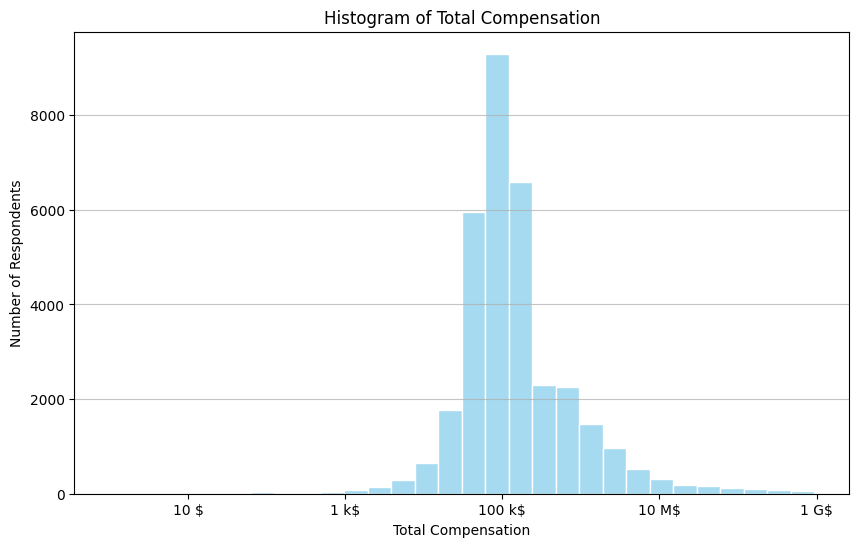

In [9]:
QUERY = """
SELECT CompTotal, COUNT(*) AS Count
FROM main
WHERE CompTotal IS NOT NULL
GROUP BY CompTotal;
"""
df_comp_total = pd.read_sql_query(QUERY, conn)

df_comp_total = df_comp_total[df_comp_total['CompTotal'] < 1e9] # exclude outliers

# create histogram
!pip install seaborn

import seaborn as sns
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=df_comp_total,
    x='CompTotal',
    weights='Count',
    log_scale=True,  # Crucial for wide-ranging data
    bins=30,
    color='skyblue',
    edgecolor='white'
)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='$')) # replace log with financial measure
plt.title('Histogram of Total Compensation')
plt.xlabel('Total Compensation')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.75)
plt.show()

**1.2 Histogram of YearsCodePro (Years of Professional Coding Experience)**


Objective: Plot a histogram of `YearsCodePro` to analyze the distribution of coding experience among respondents.


YearsCodePro Shape: (52, 2)
   YearsCodePro  Count
0             1   2639
1            10   3251
2            11   1312
3            12   1777
4            13   1127
YearsCodePro    int64
Count           int64
dtype: object


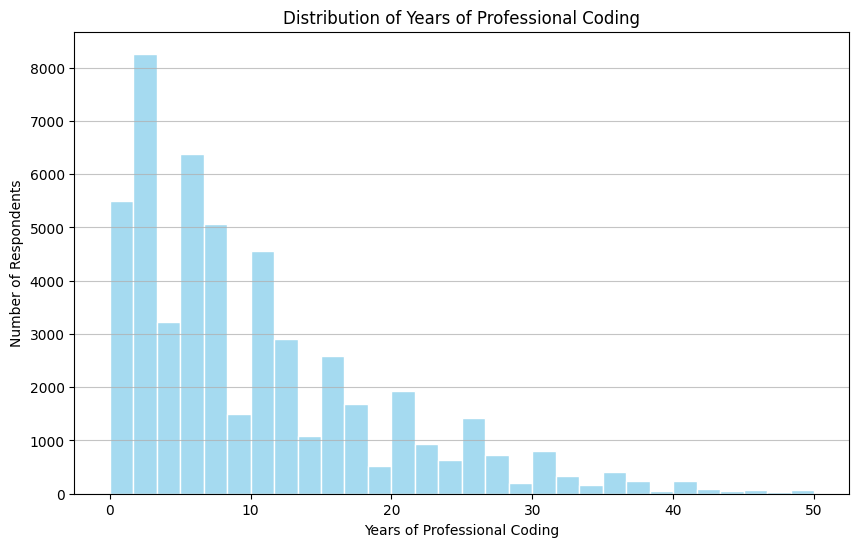

In [10]:
QUERY = """
SELECT YearsCodePro, COUNT(*) AS Count
FROM main
WHERE YearsCodePro IS NOT NULL
GROUP BY YearsCodePro;
"""
df_yearscodepro = pd.read_sql_query(QUERY, conn)

# rename yearsprocode types
df_yearscodepro['YearsCodePro'] = df_yearscodepro['YearsCodePro'].replace({
    'Less than 1 year':
        0,
    'More than 50 years':
        50,
})

#clean yearscodepro data ensure it is numeric
df_yearscodepro['YearsCodePro'] = pd.to_numeric(
    df_yearscodepro['YearsCodePro'], errors='coerce'
)

print('YearsCodePro Shape:', df_yearscodepro.shape),
print(df_yearscodepro.head())
print(df_yearscodepro.dtypes)
# create histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=df_yearscodepro,
    x='YearsCodePro',
    weights='Count',
    bins=30,
    color='skyblue',
    edgecolor='white'
)
plt.title('Distribution of Years of Professional Coding')
plt.xlabel('Years of Professional Coding')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.75)
plt.show()

### 2. Visualizing Relationships in Data


**2.1 Histogram Comparison of `CompTotal` by `Age` Group**


Objective: Use histograms to compare the distribution of CompTotal across different Age groups.


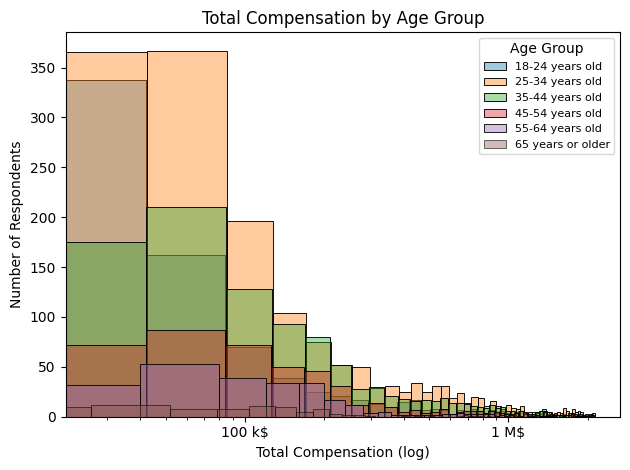

In [11]:
QUERY = """
SELECT Age, CompTotal
FROM main
WHERE Age IS NOT NULL
  AND Age != 'Prefer not to say'
  AND CompTotal IS NOT NULL
GROUP BY Age, CompTotal;
"""
df_age_comp = pd.read_sql_query(QUERY, conn)

upper  = df_age_comp['CompTotal'].quantile(0.75) + 1.5 * (df_age_comp['CompTotal'].quantile(0.75) - df_age_comp['CompTotal'].quantile(0.25)) # set upper limit of interquartile range
df_trimmed = df_age_comp[df_age_comp['CompTotal'] <= upper] # exclude CompTotal where it is above the upper limit of the interquartile range

age_groups = [
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older'
]

for g in age_groups:                                                 #loop runs once per age group
    df_age_comp = df_trimmed.loc[df_trimmed['Age'] == g, 'CompTotal']
    ax = sns.histplot(df_age_comp, bins=50, alpha=0.4, label=g)

plt.xscale('log')  # makes salary distributions readable
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='$')) # replace log with financial measure
plt.xlabel('Total Compensation (log)')
plt.ylabel('Number of Respondents')
plt.title('Total Compensation by Age Group')
plt.legend(title='Age Group', fontsize=8)
plt.tight_layout()
plt.show()

**2.2 Histogram of TimeSearching for Different Age Groups**


Objective: Use histograms to explore the distribution of `TimeSearching` (time spent searching for information) for respondents across different age groups.


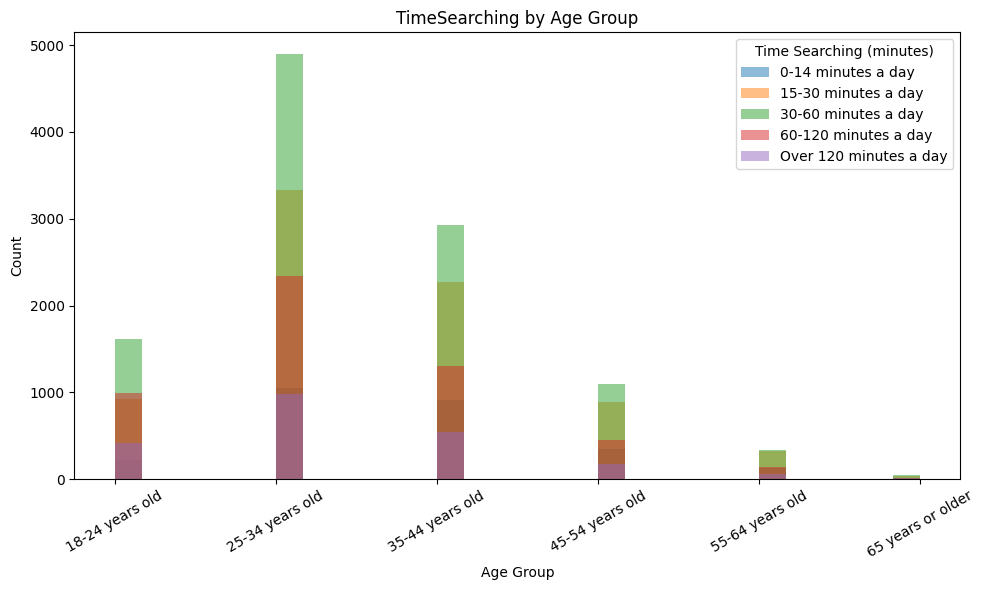

In [12]:
QUERY = """
SELECT Age, TimeSearching
FROM
(
SELECT Age,
       CASE TimeSearching
            WHEN 'Less than 15 minutes a day' THEN '0-14 minutes a day'
            ELSE TimeSearching
            END TimeSearching
       FROM main
       WHERE Age IS NOT NULL
            AND Age NOT IN ('Prefer not to say', 'Under 18 years old')
            AND TimeSearching IS NOT NULL
)
ORDER BY Age, TimeSearching
"""
df_age_searching = pd.read_sql_query(QUERY, conn)

time_searching = df_age_searching['TimeSearching'].unique()

# create histogram
plt.figure(figsize=(10,6))

for search in time_searching:
    subset = df_age_searching[df_age_searching['TimeSearching'] == search]['Age']
    plt.hist(subset ,alpha=0.5, bins=30, label=search)

plt.title("TimeSearching by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.legend(title='Time Searching (minutes)')
plt.tight_layout()
plt.show()

### 3. Visualizing the Composition of Data


**3.1 Histogram of Most Desired Databases (`DatabaseWantToWorkWith`)**


Objective: Visualize the most desired databases for future learning using a histogram of the top 5 databases.


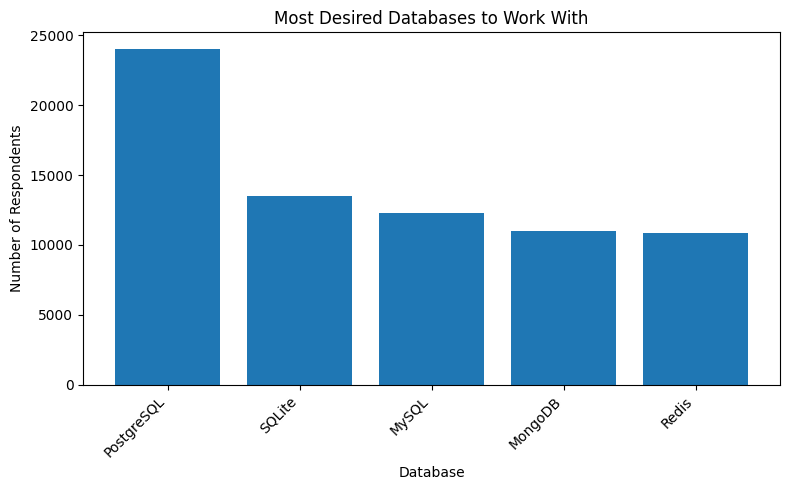

In [13]:
QUERY = """
SELECT DatabaseWantToWorkWith
FROM main
WHERE DatabaseWantToWorkWith IS NOT NULL;
"""
df_db = pd.read_sql_query(QUERY, conn)

# split, explode and count databases
db_counts = (
    df_db['DatabaseWantToWorkWith']
    .str.split(';')
    .explode()
    .value_counts(ascending=False)
    .head(5)
)

# create histogram
plt.figure(figsize=(8, 5))
plt.bar(db_counts.index, db_counts.values)
plt.xlabel('Database')
plt.ylabel('Number of Respondents')
plt.title('Most Desired Databases to Work With')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**3.2 Histogram of Preferred Work Locations (`RemoteWork`)**


Objective: Use a histogram to explore the distribution of preferred work arrangements (`remote work`).


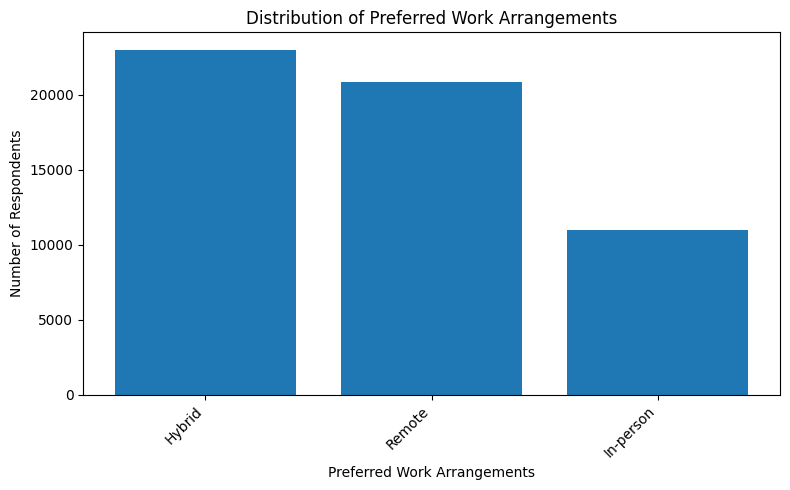

In [14]:
QUERY = """
SELECT RemoteWork
FROM
(
SELECT CASE RemoteWork
            WHEN 'Hybrid (some remote, some in-person)' THEN 'Hybrid'
            ELSE RemoteWork
            END RemoteWork
FROM main
WHERE RemoteWork IS NOT NULL
)
ORDER BY RemoteWork
"""
df_remote = pd.read_sql_query(QUERY, conn)

remote_counts = df_remote['RemoteWork'].value_counts(ascending=False)

# create histogram
plt.figure(figsize=(8, 5))
plt.bar(remote_counts.index, remote_counts.values)
plt.xlabel('Preferred Work Arrangements')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Preferred Work Arrangements')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4. Visualizing Comparison of Data


**4.1 Histogram of Median CompTotal for Ages 45 to 60**


Objective: Plot the histogram for `CompTotal` within the age group 45 to 60 to analyze compensation distribution among mid-career respondents.


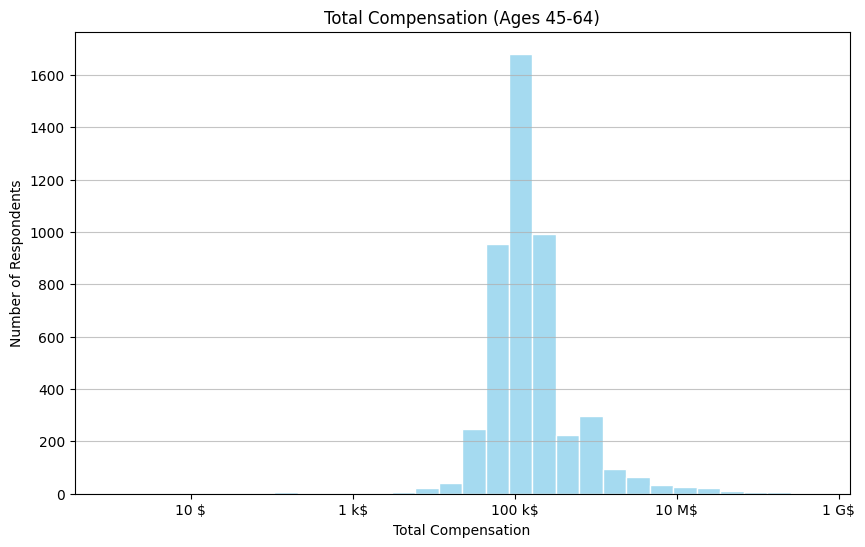

In [15]:
QUERY = """
SELECT CompTotal, COUNT(*) AS Count
FROM main
WHERE CompTotal IS NOT NULL
    AND Age IN ('45-54 years old', '55-64 years old')
GROUP BY CompTotal;
"""
df_comp_total = pd.read_sql_query(QUERY, conn)

df_comp_total = df_comp_total[df_comp_total['CompTotal'] < 1e9] # exclude outliers

df_comp_total.shape, df_comp_total.head() # check query ran

#create histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=df_comp_total,
    x='CompTotal',
    weights='Count',
    log_scale=True,  # Crucial for wide-ranging data
    bins=30,
    color='skyblue',
    edgecolor='white'
)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='$')) # replace log with financial
plt.title('Total Compensation (Ages 45-64)')
plt.xlabel('Total Compensation')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', alpha=0.75)
plt.show()

Objective: Plot the histogram for `JobSat` scores based on respondents' years of professional coding experience.


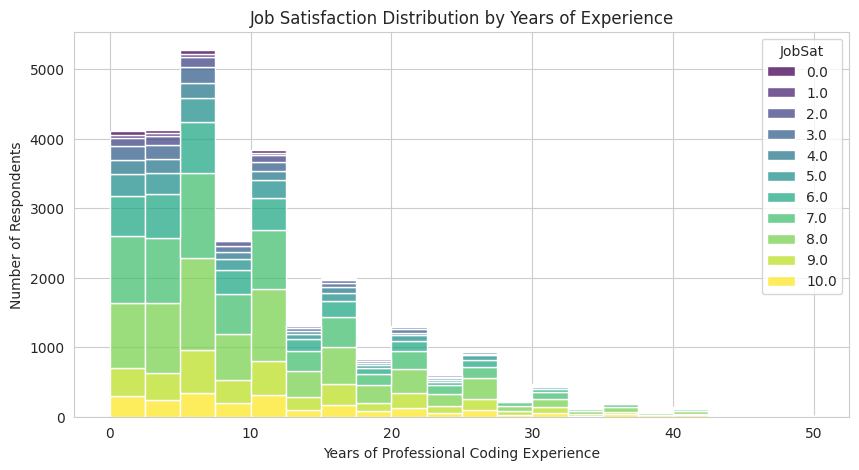

In [16]:
QUERY = """
SELECT JobSat, CAST(YearsCodePro AS float) AS YearsCodePro
FROM main
WHERE JobSat IS NOT NULL
  AND YearsCodePro IS NOT NULL;
"""
df_satis_exp = pd.read_sql_query(QUERY, conn)

# rename yearsprocode types
df_satis_exp['YearsCodePro'] = df_satis_exp['YearsCodePro'].replace({
    'Less than 1 year':
        0,
    'More than 50 years':
        50
})

# Plotting the distribution
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

sns.histplot(
    data=df_satis_exp,
    x='YearsCodePro',
    hue='JobSat', # colour bins by job satisfaction
    multiple='stack',
    bins=20,
    palette='viridis'
)
plt.title('Job Satisfaction Distribution by Years of Experience')
plt.xlabel('Years of Professional Coding Experience')
plt.ylabel('Number of Respondents')
plt.show()

### Final step: Close the database connection


Once you've completed the lab, make sure to close the connection to the SQLite database:



In [17]:
conn.close()

### Summary


In this lab, you used histograms to visualize various aspects of the dataset, focusing on:

- Distribution of compensation, coding experience, and work hours.

- Relationships in compensation across age groups and work status.

- Composition of data by desired databases and work environments.

- Comparisons of job satisfaction across years of experience.

Histograms helped reveal patterns and distributions in the data, enhancing your understanding of developer demographics and preferences.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


Copyright © IBM Corporation. All rights reserved.
